In [1]:
import os
from IPython.display import display, clear_output
from prophet import Prophet
from neuralprophet import NeuralProphet
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from scipy.stats import boxcox
from pmdarima import auto_arima

from sklearn.model_selection import train_test_split, cross_val_score, ParameterGrid, GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from sklearn.linear_model import LinearRegression, ARDRegression
from sklearn.datasets import load_diabetes
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator, RegressorMixin

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.api import ARDL
from statsmodels.tsa.ardl import ardl_select_order
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.datasets.danish_data import load

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import statsmodels.api as sm
plt.style.use('ggplot')
pd.options.display.float_format = '{:.2f}'.format

os.chdir('/Users/askar/Desktop/ВКР/Diploma.-Inflation-model-using-PCA')
os.getcwd()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.


'/Users/askar/Desktop/ВКР/Diploma.-Inflation-model-using-PCA'

In [25]:
# Дата, которая разделяет тренировочную и тестовую выборки, чтобы делить выборки для всех моделей
train_test_split_date = '2022-05-01'

# импортируем данные и делим их по дате
df = pd.read_csv('processed_regional_data/infl_rus.csv')
df['date'] = pd.date_range(start='2014-01-01', periods=len(df), freq='M')

df_train = df[df['date'] < train_test_split_date].copy()
df_test = df[df['date'] >= train_test_split_date].copy()

# Делим Датафреймы на эндогенные и экзогенные переменные
y_train = df_train['inflation']
y_test = df_test['inflation']
df_train.drop(['inflation', 'date'], axis=1, inplace=True)
df_test.drop(['inflation', 'date'], axis=1, inplace=True)
X_train = df_train.copy()
X_test = df_test.copy()

dummies_train = pd.DataFrame(0, index=y_train.index, columns=['outlier_12', 'outlier_98'])
dummies_test = pd.DataFrame(0, index=y_test.index, columns=['outlier_12', 'outlier_98'])
dummies_train.iloc[12, 0] = 1  # Дамми для индекса 12
dummies_train.iloc[98, 1] = 1  # Дамми для индекса 98

# Добавляем дамми-переменные к экзогенным факторам
X_train = pd.concat([X_train, dummies_train], axis=1)
X_test = pd.concat([X_test, dummies_test], axis=1)

WARNING - (py.warnings._showwarnmsg) - /var/folders/r7/t8m59hld1hb_kbs6vxdb07vm0000gn/T/ipykernel_16981/3909695668.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df['date'] = pd.date_range(start='2014-01-01', periods=len(df), freq='M')



## ARDL


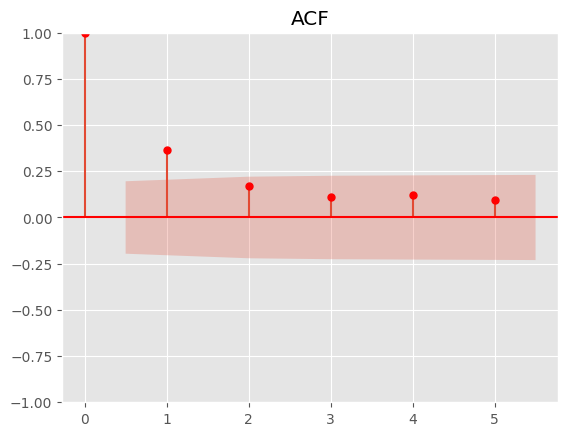

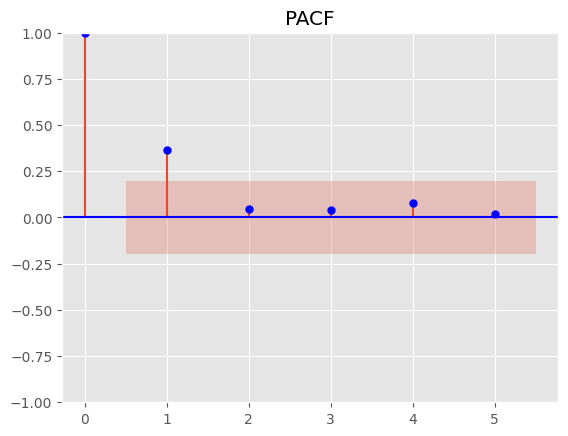

In [143]:
plot_acf(y_train, lags=5, color='r', title='ACF');
plot_pacf(y_train, lags=5, color='b', title='PACF');

[["debt_firms", "debt_fiz", "Brent", "MIACR", "obligates", "paid_services", 
                         "salary", "M2", "gov_debt", "Infl_exp", "PCA_1", "PCA_2", "PCA_3"]]

In [56]:
from statsmodels.datasets.danish_data import load
from statsmodels.tsa.api import ARDL
from statsmodels.tsa.ardl import ardl_select_order
res = ARDL(
    y_train, 
    1, 
    X_train,
    {"debt_fiz": 1, 
     "Brent": 1, 
     "MIACR": 1, 
     "obligates": 1, 
     "salary": 0, 
     "M2": 0, 
     "gov_debt": 0, 
     "Infl_exp": 1, 
     "PCA_1": 1, 
     "PCA_2": 1, 
     "PCA_3": 1, 
     "outlier_12": 1, 
     "outlier_98": 1}, 
    trend="c"
).fit()
print(res.summary())

WARNING - (py.warnings._showwarnmsg) - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/ardl/model.py:455: SpecificationWarning: exog contains variables that are missing from the order dictionary.  Missing keys: debt_firms, paid_services.
  return _format_order(self.data.orig_exog, order, self._causal)



                                            ARDL Model Results                                            
Dep. Variable:                                          inflation   No. Observations:                  100
Model:             ARDL(1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1)   Log Likelihood                  53.371
Method:                                           Conditional MLE   S.D. of innovations              0.141
Date:                                            Fri, 25 Apr 2025   AIC                            -54.743
Time:                                                    00:26:28   BIC                             12.730
Sample:                                                         1   HQIC                           -27.443
                                                              100                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------

## XGBoost


WARNING - (py.warnings._showwarnmsg) - /var/folders/r7/t8m59hld1hb_kbs6vxdb07vm0000gn/T/ipykernel_7163/820438566.py:36: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  y_train['ds'] = pd.date_range(

WARNING - (py.warnings._showwarnmsg) - /var/folders/r7/t8m59hld1hb_kbs6vxdb07vm0000gn/T/ipykernel_7163/820438566.py:38: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  y_test['ds'] = pd.date_range(end='2023-08-31', freq='M', periods=len(y_test))



Mean Squared Error: 5.0620
Best params: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}


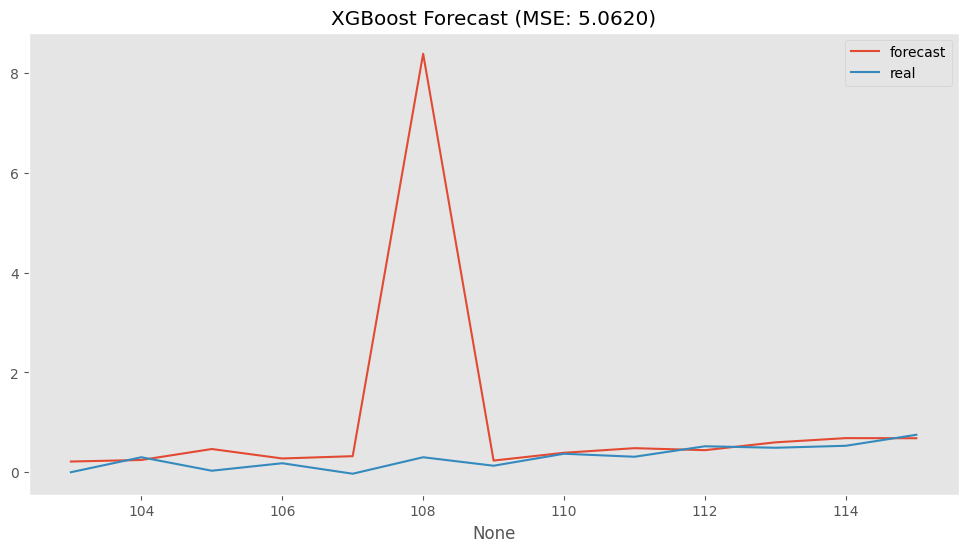

In [112]:
def create_features(df, target_col='inflation', n_lags=3, window_size=3):
    """
    Создает временные признаки для модели:
    - Лаги (авторегрессионная компонента)
    - Скользящие статистики
    - Временные фичи из даты
    """
    df = df.copy()

    # 1. Авторегрессионные компоненты (лаги)
    for lag in range(1, n_lags+1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)

    # 2. Скользящие статистики
    df['rolling_mean'] = df[target_col].rolling(
        window=window_size).mean().shift(1)
    df['rolling_std'] = df[target_col].rolling(
        window=window_size).std().shift(1)

    # 3. Временные фичи из даты
    df['month'] = df['ds'].dt.month
    df['quarter'] = df['ds'].dt.quarter
    df['year'] = df['ds'].dt.year
    df['days_in_month'] = df['ds'].dt.days_in_month

    # 4. Дополнительные преобразования
    df['time_idx'] = (df['ds'] - df['ds'].min()).dt.days

    return df.dropna()


# Загрузка данных
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

y_train['ds'] = pd.date_range(
    start='2014-01-01', freq='M', periods=len(y_train))
y_test['ds'] = pd.date_range(end='2023-08-31', freq='M', periods=len(y_test))

# Создаем фичи для train и test
train_feats = create_features(y_train)
test_feats = create_features(y_test)


# Разделяем на X и y
X_train_infl = train_feats.drop(columns=['inflation', 'ds']).join(X_train)
y_train = train_feats['inflation']

X_test_infl = test_feats.drop(columns=['inflation', 'ds']).join(X_test)
y_test = test_feats['inflation']

# Настройка кросс-валидации для временных рядов
tscv = TimeSeriesSplit(n_splits=3)
# Параметры для подбора
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Инициализация и обучение модели
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)
grid_search = GridSearchCV(
    xgb_model, param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_infl, y_train)

# Предсказание
xgb_pred = grid_search.predict(X_test_infl)

# Оценка качества
mse = mean_squared_error(y_test, xgb_pred)
print(f"Mean Squared Error: {mse:.4f}")
print(f"Best params: {grid_search.best_params_}")

# Визуализация
plt.figure(figsize=(12, 6))
sb.lineplot(x=y_test.index, y=xgb_pred, label='forecast')
y_test.plot(label='real')
plt.title(f"XGBoost Forecast (MSE: {mse:.4f})")
plt.legend()
plt.grid()
plt.show()